In [53]:
import sys
import pandas as pd
sys.path.insert(1, '../../../scripts/')
from s3_support import *
%matplotlib inline

In [59]:
q = "select * from googleanalytics_referrer"
df = redshift_query_read(q, schema="public")

In [60]:
df.head(3)

,date,org,form,views,path,source,qgiv_frontend,p2p_frontend,facebook,twitter
0,2020-08-18,0,0,1,/account/1372318/payments/,(direct),False,False,False,False
1,2020-08-29,0,0,1,/account/1444428/recurring/,(direct),False,False,False,False
2,2020-09-27,0,0,2,/account/1333201/payments/,google,False,False,False,False


In [8]:
df[df['org']!=0][['facebook', 'twitter']].sum() / len(df)

facebook    0.180152
twitter     0.004528
dtype: float64

In [10]:
soc_df = df[df['org']!=0].groupby('org')[['views', 'facebook', 'twitter']].sum().reset_index()
soc_df['facebook_perc'] = soc_df['facebook'] / soc_df['views']
soc_df['twitter_perc'] = soc_df['twitter'] / soc_df['views']
soc_df.tail(3)

,org,views,facebook,twitter,facebook_perc,twitter_perc
3250,446318,2,0.0,0.0,0.0,0.0
3251,446334,6,0.0,0.0,0.0,0.0
3252,446344,6,0.0,0.0,0.0,0.0


In [34]:
perc_fb_avg_all = soc_df['facebook_perc'].mean()
perc_tw_avg_all = soc_df['twitter_perc'].mean()
perc_fb_avg_act = soc_df[soc_df['facebook']>0]['facebook_perc'].mean()
perc_tw_avg_act = soc_df[soc_df['twitter']>0]['twitter_perc'].mean()

print("Mean fb traffic (all): {:.1f}%".format(perc_fb_avg_all * 100.))
print("Mean tw traffic (all): {:.1f}%".format(perc_tw_avg_all * 100.))
print("Mean fb traffic (w/ fb views): {:.1f}%".format(perc_fb_avg_act * 100.))
print("Mean tw traffic (w/ tw views): {:.1f}%".format(perc_tw_avg_act * 100.))

Mean fb traffic (all): 3.5%
Mean tw traffic (all): 0.1%
Mean fb traffic (w/ fb views): 8.6%
Mean tw traffic (w/ tw views): 0.8%


In [33]:
fb_orgs = soc_df[soc_df['facebook']>0]['org'].tolist()
tw_orgs = soc_df[soc_df['twitter']>0]['org'].tolist()
soc_orgs = list(set(fb_orgs) & set(tw_orgs))

len_both = len(soc_orgs)
perc_both = (float(len_both) / float(len(soc_df))) * 100.
len_fb = len(fb_orgs)
perc_fb = (float(len_fb) / float(len(soc_df))) * 100.
len_tw = len(tw_orgs)
perc_tw = (float(len_tw) / float(len(soc_df))) * 100.

print("{} ({:.1f}%) orgs w/ both fb & tw".format(len_both, perc_both))
print("{} ({:.1f}%) facebook orgs".format(len_fb, perc_fb))
print("{} ({:.1f}%) twitter orgs".format(len_tw, perc_tw))
print("{} orgs in tw not in fb".format(len([o for o in tw_orgs if o not in fb_orgs])))

330 (10.1%) orgs w/ both fb & tw
1327 (40.8%) facebook orgs
341 (10.5%) twitter orgs
11 orgs in tw not in fb


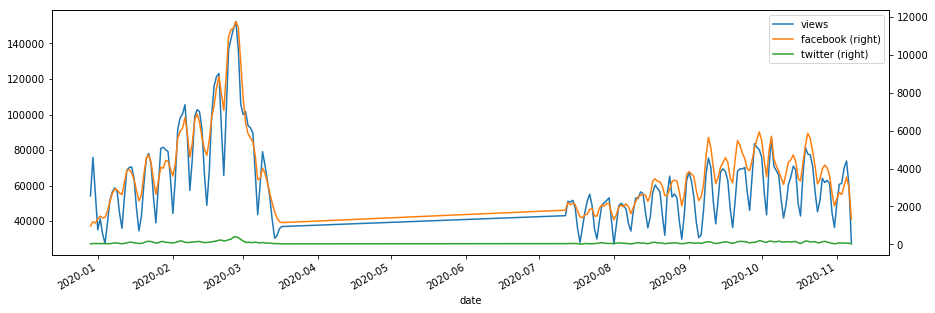

In [52]:
df.groupby('date')[['views', 'facebook', 'twitter']].sum().reset_index().plot(x='date', y=['views', 'facebook', 'twitter'], secondary_y=['facebook', 'twitter'], figsize=(15,5))

# processing

In [16]:
start_date = df['date'].min()
q = "select * from transactions where status='A' and date>='{}'".format(start_date)
trans = redshift_query_read(q, schema="public")

In [40]:
org_trans = trans.groupby('org')['amount'].agg({'sum', 'count', 'mean', 'median'}).reset_index()
org_trans = org_trans.merge(soc_df, on='org')

In [43]:
fb_act_avg = org_trans[org_trans['facebook']>0][['count', 'sum', 'mean', 'median']].mean()
tw_act_avg = org_trans[org_trans['twitter']>0][['count', 'sum', 'mean', 'median']].mean()
no_act_avg = org_trans[(org_trans['facebook']==0)&(org_trans['twitter']==0)][['count', 'sum', 'mean', 'median']].mean()

print("No social sources:\n {:,.2f} transactions, ${:,.2f} volume, ${:,.2f} avg trans size, ${:,.2f} median trans size".format(no_act_avg['count'], no_act_avg['sum'], no_act_avg['mean'], no_act_avg['median']))
print("Facebook sources:\n {:,.2f} transactions, ${:,.2f} volume, ${:,.2f} avg trans size, ${:,.2f} median trans size".format(fb_act_avg['count'], fb_act_avg['sum'], fb_act_avg['mean'], fb_act_avg['median']))
print("Twitter sources:\n {:,.2f} transactions, ${:,.2f} volume, ${:,.2f} avg trans size, ${:,.2f} median trans size".format(tw_act_avg['count'], tw_act_avg['sum'], tw_act_avg['mean'], tw_act_avg['median']))

No social sources:
 373.29 transactions, $176,605.68 volume, $317.08 avg trans size, $86.99 median trans size
Facebook sources:
 1,131.19 transactions, $125,391.84 volume, $142.70 avg trans size, $58.21 median trans size
Twitter sources:
 2,382.46 transactions, $241,729.16 volume, $144.31 avg trans size, $51.79 median trans size


# importing

In [58]:
q = '''copy googleanalytics_referrer
        from 's3://qgiv-stats-data/ga_referrer.csv'
        iam_role 'arn:aws:iam::637885584661:role/AWSRoleForRedshift'
        emptyasnull
        blanksasnull
        fillrecord
        delimiter ','
        ignoreheader 1
        region 'us-east-1';'''
redshift_query_write(q, schema='public')